In [ ]:
#!pip install connectivipy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import connectivipy as cp
from connectivipy import mvar_gen
import networkx as nx
import seaborn
from collections import OrderedDict 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def import_data(file):
    '''
    importing data CE or OE
    '''
    OE = pd.read_csv(file, skiprows=[1])
    for c in OE.columns:
        OE = OE.rename(columns={c:c.strip("'")})
    ysig = OE.drop(columns=['Elapsed time','EDF Annotations'])
        
    return ysig
OE = import_data('/content/drive/MyDrive/Bio-project/project2/S064R01.csv')
CE = import_data('/content/drive/MyDrive/Bio-project/project2/S064R02.csv')

In [ ]:
def estimator(arr, typ='PDC'):
    mv = cp.Mvar
    # find best model order using Vieira-Morf algorithm
    best, crit = mv.order_akaike(arr.T, 15, 'vm')
    av, vf = mv.fit(arr.T, best, 'vm')
    
    if typ == 'PDC':
        pdc = cp.conn.PDC()
        val = pdc.calculate(av, vf, 160, resolution=80)
    else:
        dtf = cp.conn.DTF()
        val = dtf.calculate(av, vf, 160, resolution=80)
        
    return val

In [ ]:
def adj_matrix(density, frequency, val, verbose=1):
    dens = 1
    treshold = 0
    while dens >= density:
        treshold += 0.001
        mat = val[frequency,:,:,]
        adj_mat = np.zeros_like(mat)
        adj_mat[mat>=treshold] = 1
        adj_mat -= adj_mat*np.identity(adj_mat.shape[0])
        G = nx.from_numpy_matrix(adj_mat, create_using=nx.DiGraph())
        dens = nx.density(G)
    if verbose:
      print(f'the right treshold is {round(treshold, 2)}')
      print(f'density = {dens}')
      
    return G, adj_mat, mat  

# EX 1.1 and 1.3

In [ ]:
arr_OE = np.array(OE)
arr_CE = np.array(CE)
dtfval_OE = estimator(arr_OE, 'DTF')
dtfval_CE = estimator(arr_CE, 'DTF')
pdcval_OE = estimator(arr_OE, 'PDC')
pdcval_CE = estimator(arr_CE, 'PDC')

In [ ]:
G_OE, adj_mat_OE, mat_OE = adj_matrix(0.2, 30, dtfval_OE)

the right treshold is 0.12
density = 0.19692460317460317


In [ ]:
G_CE, adj_mat_CE, mat_CE = adj_matrix(0.2, 30, dtfval_CE)

the right treshold is 0.13
density = 0.19717261904761904


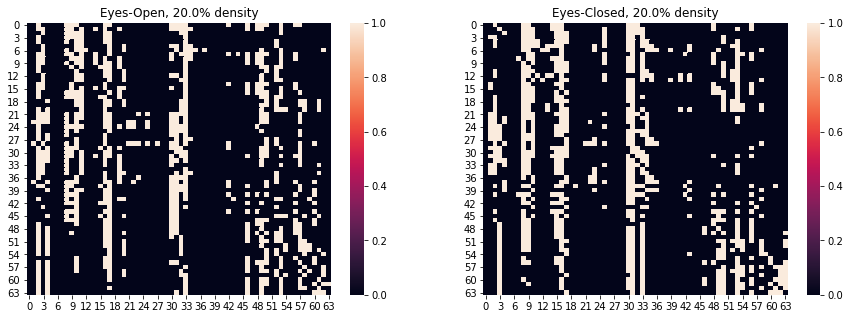

In [ ]:
def plot_two_adj(adj_OE, adj_CE, thr, suptitle=None):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  seaborn.heatmap(adj_OE, ax=ax1)
  seaborn.heatmap(adj_CE, ax=ax2)
  ax1.set_title(f'Eyes-Open, {str(thr*100) + "% density" if type(thr) is float else thr}')
  ax2.set_title(f'Eyes-Closed, {str(thr*100) + "% density" if type(thr) is float else thr}')
  if suptitle:
    plt.suptitle(suptitle)
  plt.show()
plot_two_adj(adj_mat_OE, adj_mat_CE, 0.2)  

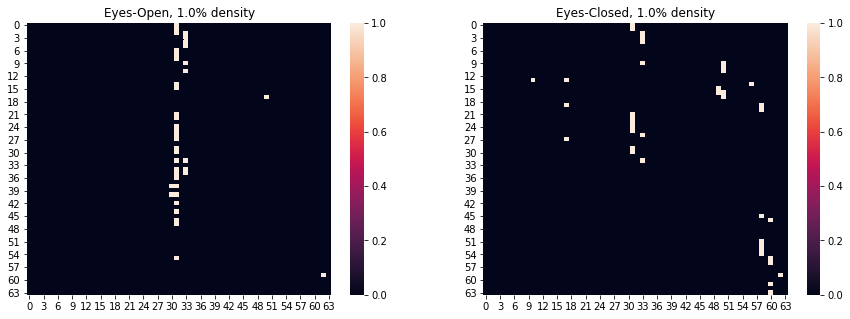

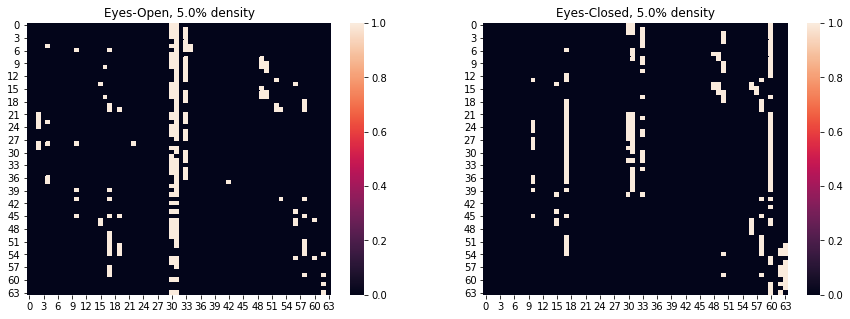

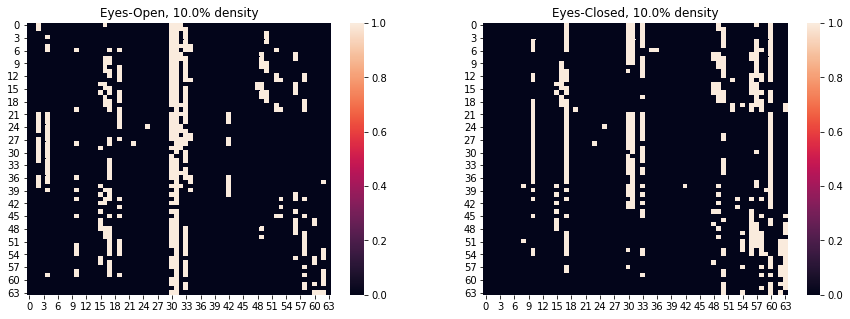

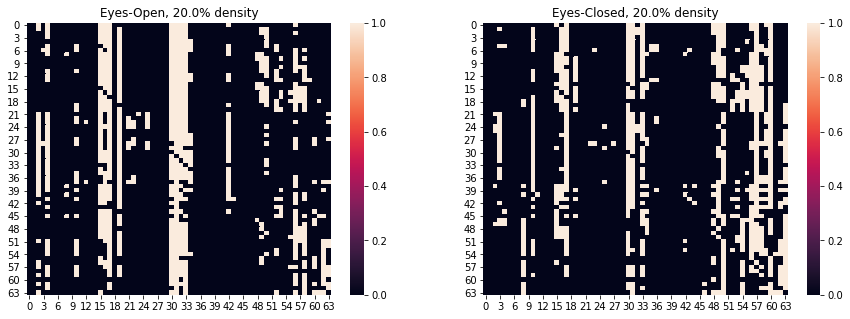

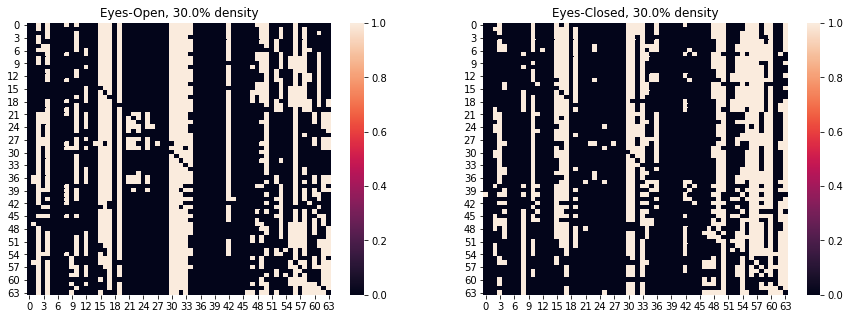

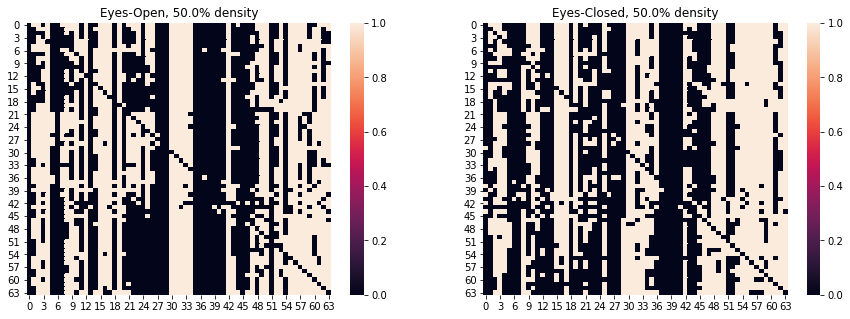

In [ ]:
for th in [0.01,0.05,0.1,0.2,0.3,0.5]:
  G_OE, adj_mat_OE, mat_OE = adj_matrix(th, 10, dtfval_OE, verbose= 0)
  G_CE, adj_mat_CE, mat_CE = adj_matrix(th, 10, dtfval_CE, verbose= 0)
  plot_two_adj(adj_mat_OE, adj_mat_CE, th)

# EX 1.2

the right treshold is 0.13
density = 0.1956845238095238
the right treshold is 0.13
density = 0.1984126984126984


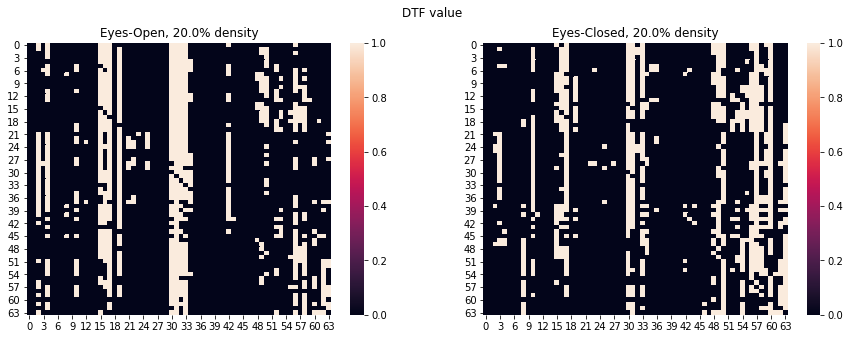

the right treshold is 0.1
density = 0.19469246031746032
the right treshold is 0.11
density = 0.19518849206349206


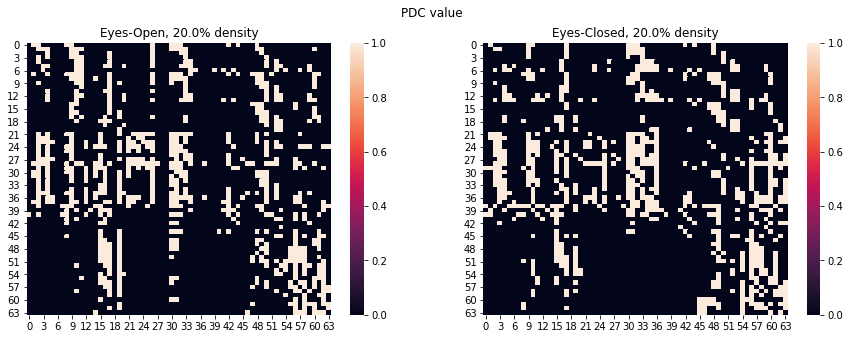

In [ ]:
th = 0.2
for i, (val_OE, val_CE) in enumerate([(dtfval_OE, dtfval_CE), (pdcval_OE, pdcval_CE)]):
  G_OE, adj_mat_OE, mat_OE = adj_matrix(th, 10, val_OE)
  G_CE, adj_mat_CE, mat_CE = adj_matrix(th, 10, val_CE)
  plot_two_adj(adj_mat_OE, adj_mat_CE, th, suptitle=['DTF value','PDC value'][i])

# EX 1.5

In [ ]:
ch_19 = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 
         'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']
for i, c in enumerate(ch_19):
    while len(c) < 4:
        c += '.'
    ch_19[i] = c
channel_loc = pd.read_csv('/content/drive/MyDrive/Bio-project/project2/channel_locations.txt', sep=8*'\s', engine='python',
 skiprows=1, header=None)
channel_loc.drop(0, axis=1)

mapping_19 = {}
for i, c in enumerate(ch_19):
    mapping_19[i] = c

pos = {i[1][1]: (i[1][2], i[1][3]) for i in channel_loc.iterrows()}

mapping = {}
for i, c in enumerate(OE.columns):
    mapping[i] = c

In [ ]:
OE_19 = OE[ch_19]
CE_19 = CE[ch_19]

In [ ]:
arr_OE19 = np.array(OE_19)
arr_CE19 = np.array(CE_19)
dtfval_OE19 = estimator(arr_OE19, 'DTF')
dtfval_CE19 = estimator(arr_CE19, 'DTF')

the right treshold is 0.24
density = 0.14912280701754385
the right treshold is 0.29
density = 0.14912280701754385


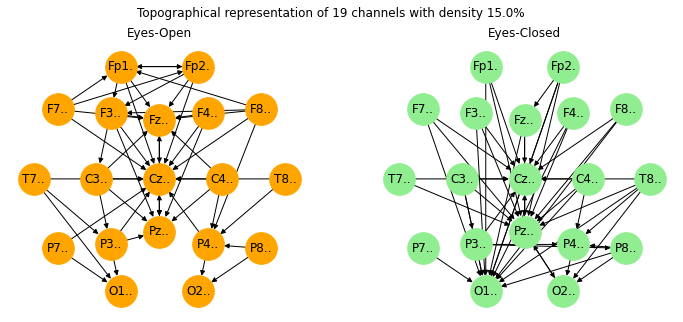

In [ ]:
th=0.15
G_OE19, adj_mat_OE19, mat_OE19 = adj_matrix(th, 10, dtfval_OE19)
G_CE19, adj_mat_CE19, mat_CE19 = adj_matrix(th, 10, dtfval_CE19)
G_OE19 = nx.relabel_nodes(G_OE19, mapping_19)
G_CE19 = nx.relabel_nodes(G_CE19, mapping_19)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
nx.draw(G_OE19, pos, with_labels=True, node_color='orange', node_size=1000, ax=ax1)
nx.draw(G_CE19, pos, with_labels=True, node_color='lightgreen', node_size=1000, ax=ax2)
f.suptitle(f'Topographical representation of 19 channels with density {th*100}%')
ax1.set_title('Eyes-Open')
ax2.set_title('Eyes-Closed')
plt.show()

# EX 1.4

In [ ]:
!pip install scot
import scot
from scipy.stats import norm
from matplotlib.lines import Line2D

     |████████████████████████████████| 61kB 3.1MB/s 


In [ ]:
mv = cp.Mvar
arr_OE19 = np.array(OE_19)
best_OE19, crit = mv.order_akaike(arr_OE19.T, 15, 'vm')
arr_CE19 = np.array(CE_19)
best_CE19, crit = mv.order_akaike(arr_CE19.T, 15, 'vm')
dtfval_OE19 = estimator(arr_OE19, 'DTF')
dtfval_CE19 = estimator(arr_CE19, 'DTF')

In [ ]:
mvar_OE = scot.var.VAR(best_OE19)
surr_OE = scot.connectivity_statistics.surrogate_connectivity('DTF', arr_OE19.T, mvar_OE, repeats=1000, n_jobs=-1, nfft=80)
mvar_CE = scot.var.VAR(best_CE19)
surr_CE = scot.connectivity_statistics.surrogate_connectivity('DTF', arr_CE19.T, mvar_CE, repeats=1000, n_jobs=-1, nfft=80)

In [ ]:
freq_OE = dtfval_OE19[10,:,:].copy()
freq_CE = dtfval_CE19[10,:,:].copy()
p_vals_OE = norm.sf(freq_OE, loc=np.mean(surr_OE[:,:,:,10], axis=0), scale = np.std(surr_OE[:,:,:,10], axis=0))
p_vals_CE = norm.sf(freq_CE, loc=np.mean(surr_CE[:,:,:,10], axis=0), scale = np.std(surr_CE[:,:,:,10], axis=0))
freq_OE[p_vals_OE>0.05] = 0
freq_CE[p_vals_CE>0.05] = 0


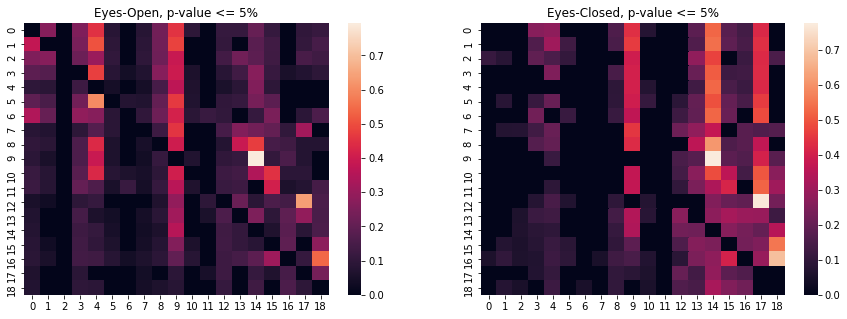

In [ ]:
plot_two_adj(freq_OE, freq_CE, thr='p-value <= 5%')

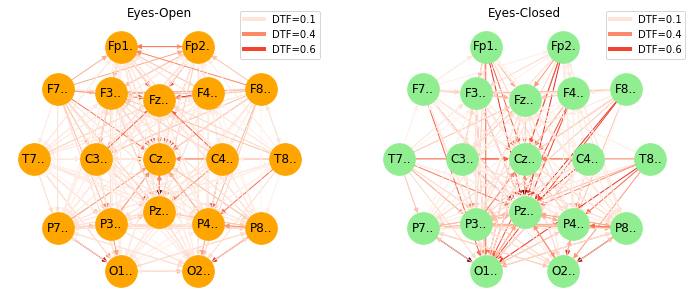

In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(12,5))
for i, freq in enumerate([freq_OE, freq_CE]):
    G_sign = nx.convert_matrix.from_numpy_matrix(freq, create_using=nx.DiGraph(weighted=True))
    G_sign = nx.relabel_nodes(G_sign, mapping_19)
    cmap = plt.cm.Reds
    nx.draw(G_sign, pos, ax = ax[i], with_labels=True, node_color=['orange', 'lightgreen'][i], node_size=1000, edge_color = nx.get_edge_attributes(G_sign,'weight').values(), edge_cmap=cmap)

    custom_lines = [Line2D([0], [0], color=cmap(.1), lw=4),
                    Line2D([0], [0], color=cmap(.4), lw=4),
                    Line2D([0], [0], color=cmap(.6), lw=4)]


    ax[i].legend(custom_lines, ['DTF=0.1', 'DTF=0.4', 'DTF=0.6'], bbox_to_anchor=(0.75, 0.85))
    ax[i].set_title(['Eyes-Open', 'Eyes-Closed'][i])
plt.show(fig)

# EX 1.6

the right treshold is 0.12
density = 0.19692460317460317
the right treshold is 0.13
density = 0.19717261904761904
the right treshold is 0.13
density = 0.1956845238095238
the right treshold is 0.13
density = 0.1984126984126984


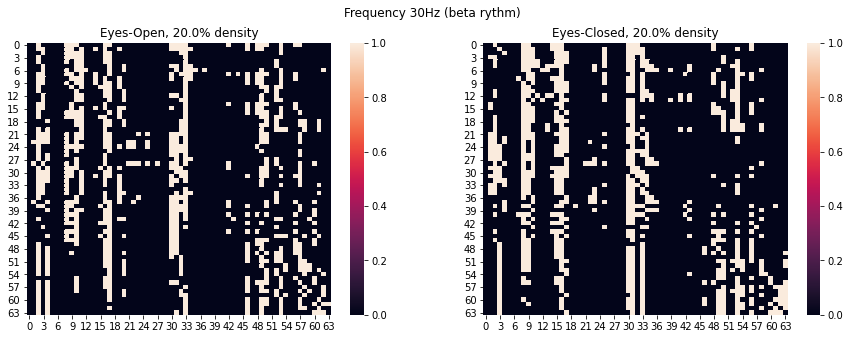

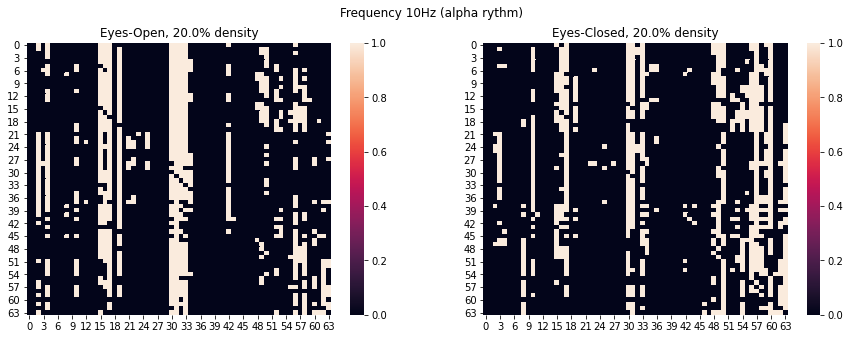

In [ ]:
# Changing frequency value to 20 (Beta Rythm)
th=0.2
G_OE_beta, adj_mat_OE_beta, mat_OE_beta = adj_matrix(th, 30, dtfval_OE)
G_CE_beta, adj_mat_CE_beta, mat_CE_beta = adj_matrix(th, 30, dtfval_CE)
G_OE, adj_mat_OE, mat_OE = adj_matrix(th, 10, dtfval_OE)
G_CE, adj_mat_CE, mat_CE = adj_matrix(th, 10, dtfval_CE)
plot_two_adj(adj_mat_OE_beta, adj_mat_CE_beta, th, suptitle='Frequency 30Hz (beta rythm)')
plot_two_adj(adj_mat_OE, adj_mat_CE, th, suptitle='Frequency 10Hz (alpha rythm)')

# EX 2.1, EX 2.3, EX 2.4 and EX 2.6

In [ ]:
arr_OE = np.array(OE)
arr_CE = np.array(CE)
dtfval_OE = estimator(arr_OE, 'DTF')
dtfval_CE = estimator(arr_CE, 'DTF')

In [ ]:
G_OE, adj_mat_OE, mat_OE = adj_matrix(0.20, 10, dtfval_OE)
G_CE, adj_mat_CE, mat_CE = adj_matrix(0.20, 10, dtfval_CE)

the right treshold is 0.13
density = 0.1956845238095238
the right treshold is 0.13
density = 0.1984126984126984


In [ ]:
G_OE = nx.relabel_nodes(G_OE, mapping)
G_CE = nx.relabel_nodes(G_CE, mapping)

In [ ]:
def print_global_indices(dens, dtfval_OE,dtfval_CE ):
  # global graph indices
  G_OE, adj_mat_OE, mat_OE = adj_matrix(dens, 10, dtfval_OE, verbose=0)
  G_CE, adj_mat_CE, mat_CE = adj_matrix(dens, 10, dtfval_CE, verbose=0)
  print(f'global indices for eyes-opened (density = {dens*100}%)')
  print(f'average clustering coefficient {nx.average_clustering(G_OE)}')
  print(f'average path lenght {nx.average_shortest_path_length(G_OE)}')
  print()
  print(f'global indices for eyes-closed (density = {dens*100}%)')
  print(f'average clustering coefficient {nx.average_clustering(G_CE)}')
  print(f'average path lenght {nx.average_shortest_path_length(G_CE)}')
  print()


for dens in [0.1,0.2,0.3,0.5]:
  print_global_indices(dens, dtfval_OE, dtfval_CE )


global indices for eyes-opened (density = 10.0%)
average clustering coefficient 0.2838618372773882
average path lenght 1.0424107142857142

global indices for eyes-closed (density = 10.0%)
average clustering coefficient 0.3614044600430951
average path lenght 1.0193452380952381

global indices for eyes-opened (density = 20.0%)
average clustering coefficient 0.42225181917024635
average path lenght 0.9528769841269841

global indices for eyes-closed (density = 20.0%)
average clustering coefficient 0.4795145177013526
average path lenght 1.2036210317460319

global indices for eyes-opened (density = 30.0%)
average clustering coefficient 0.502117051566991
average path lenght 1.2718253968253967

global indices for eyes-closed (density = 30.0%)
average clustering coefficient 0.5213741153025916
average path lenght 1.818452380952381

global indices for eyes-opened (density = 50.0%)
average clustering coefficient 0.6092184899086778
average path lenght 1.6158234126984128

global indices for eyes-clos

In [ ]:
# local graph indices OE
def local_indices(G, state, w=None):
  degree = dict(G.degree(weight=w))
  in_degree = dict(G.in_degree(weight=w))
  out_degree = dict(G.out_degree(weight=w))
  top_10_degree = sorted(degree, key=degree.get, reverse=True)[:10]
  top_10_in_degree = sorted(in_degree, key=in_degree.get, reverse=True)[:10]
  top_10_out_degree = sorted(out_degree, key=out_degree.get, reverse=True)[:10]
  print(f'local indices for eyes-{state}')
  print()
  print('top 10 nodes for degree')
  print(top_10_degree)
  print('top 10 nodes for in degree')
  print(top_10_in_degree)
  print('top 10 nodes for out degree')
  print(top_10_out_degree)
  return degree, in_degree, out_degree

deg_OE, indeg_OE, outdeg_OE = local_indices(G_OE, 'opened', )

local indices for eyes-opened

top 10 nodes for degree
['Cpz.', 'Cp1.', 'Fz..', 'Fc1.', 'P1..', 'F3..', 'Cz..', 'C3..', 'F5..', 'Pz..']
top 10 nodes for in degree
['Cpz.', 'Fc1.', 'Fz..', 'Cp1.', 'Cz..', 'P1..', 'F5..', 'C3..', 'F3..', 'Pz..']
top 10 nodes for out degree
['C5..', 'F3..', 'Fc5.', 'Af8.', 'Fc3.', 'Fp1.', 'Fp2.', 'F8..', 'C3..', 'Af7.']


In [ ]:
deg_CE, indeg_CE, outdeg_CE =local_indices(G_CE, 'closed')

local indices for eyes-closed

top 10 nodes for degree
['F3..', 'Cp1.', 'C3..', 'F5..', 'Fz..', 'P6..', 'C1..', 'Cp3.', 'Fc1.', 'Cz..']
top 10 nodes for in degree
['F3..', 'Cp1.', 'F5..', 'C3..', 'Fz..', 'C1..', 'P6..', 'Cp3.', 'Cz..', 'Cpz.']
top 10 nodes for out degree
['Fc4.', 'F3..', 'Fc6.', 'C4..', 'C6..', 'Cp6.', 'P2..', 'Fc3.', 'Fc2.', 'Af8.']


# EX 2.2

In [ ]:
G1 = G_OE.to_undirected()
G2 = G_CE.to_undirected()

In [ ]:
#Small-Worldness Index

##sigma_OE = nx.sigma(G1, 10, 10)
omega_OE = nx.omega(G1, 10, 3)
#print(f'sigma index for OE = {sigma_OE}')
print(f'omega index for OE = {omega_OE}')


#sigma_CE = nx.sigma(G2, 10, 10)
omega_CE = nx.omega(G2, 10, 3)
#print(f'sigma index for CE = {sigma_CE}')
print(f'omega index for CE = {omega_CE}')


omega index for OE = 0.03202302779526833
omega index for CE = 0.03936227706719486


# EX 2.5

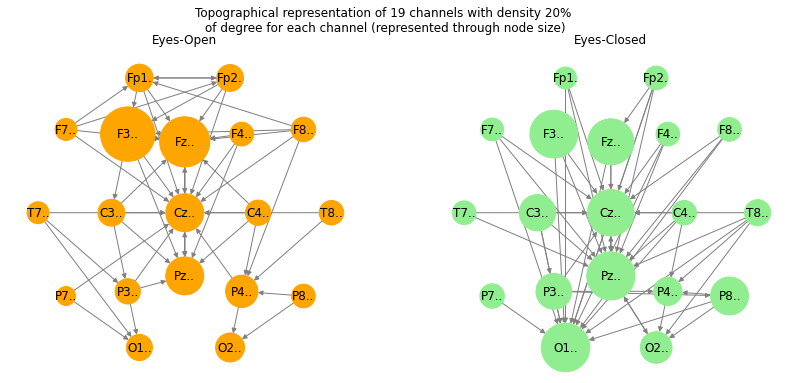

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6), sharey=True)

nx.draw(G_OE19, pos, with_labels=True, node_color='orange', edge_color='gray', node_size=[v*40 for v in [deg_OE[k] for k in mapping_19.values()]], ax=ax1)
nx.draw(G_CE19, pos, with_labels=True, node_color='lightgreen',edge_color='gray', node_size=[v*40 for v in [deg_CE[k] for k in mapping_19.values()]], ax=ax2)
f.suptitle('Topographical representation of 19 channels with density 20% \nof degree for each channel (represented through node size)')
ax1.set_title('Eyes-Open')
ax2.set_title('Eyes-Closed')
plt.show()

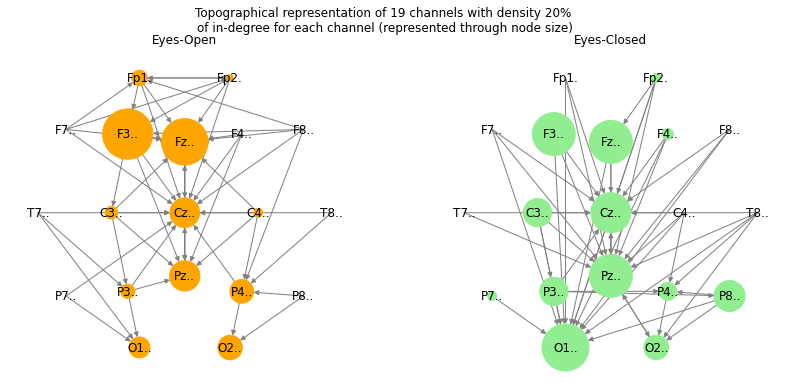

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6), sharey=True)

nx.draw(G_OE19, pos, with_labels=True, node_color='orange', edge_color='gray', node_size=[v*40 for v in [indeg_OE[k] for k in mapping_19.values()]], ax=ax1)
nx.draw(G_CE19, pos, with_labels=True, node_color='lightgreen',edge_color='gray', node_size=[v*40 for v in [indeg_CE[k] for k in mapping_19.values()]], ax=ax2)
f.suptitle('Topographical representation of 19 channels with density 20% \nof in-degree for each channel (represented through node size)')
ax1.set_title('Eyes-Open')
ax2.set_title('Eyes-Closed')
plt.show()

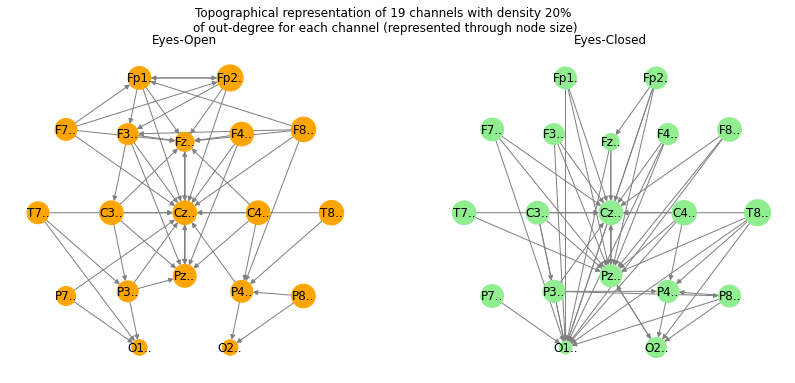

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6), sharey=True)

nx.draw(G_OE19, pos, with_labels=True, node_color='orange', edge_color='gray', node_size=[v*40 for v in [outdeg_OE[k] for k in mapping_19.values()]], ax=ax1)
nx.draw(G_CE19, pos, with_labels=True, node_color='lightgreen',edge_color='gray', node_size=[v*40 for v in [outdeg_CE[k] for k in mapping_19.values()]], ax=ax2)
f.suptitle('Topographical representation of 19 channels with density 20% \nof out-degree for each channel (represented through node size)')
ax1.set_title('Eyes-Open')
ax2.set_title('Eyes-Closed')
plt.show()

# EX 2.7

In [ ]:
G_weighted_OE = nx.convert_matrix.from_numpy_matrix(mat_OE, create_using=nx.DiGraph(weighted=True))
G_weighted_OE = nx.relabel_nodes(G_weighted_OE, mapping)

G_weighted_CE = nx.convert_matrix.from_numpy_matrix(mat_CE, create_using=nx.DiGraph(weighted=True))
G_weighted_CE = nx.relabel_nodes(G_weighted_CE, mapping)

In [ ]:
deg_OE, indeg_OE, outdeg_OE = local_indices(G_weighted_OE, 'opened', w='weight')

local indices for eyes-opened

top 10 nodes for degree
['F3..', 'F5..', 'Fz..', 'Cpz.', 'Cp4.', 'F1..', 'Fc2.', 'Cp3.', 'Po3.', 'Po4.']
top 10 nodes for in degree
['F3..', 'F5..', 'Fz..', 'Cpz.', 'Cp4.', 'Fc2.', 'F1..', 'Po3.', 'Po4.', 'Cp3.']
top 10 nodes for out degree
['Af8.', 'F8..', 'Fp2.', 'Af4.', 'Fc6.', 'Ft8.', 'F6..', 'Af7.', 'Fp1.', 'Fpz.']


In [ ]:
deg_CE, indeg_CE, outdeg_CE = local_indices(G_weighted_CE, 'closed', w='weight')

local indices for eyes-closed

top 10 nodes for degree
['O1..', 'Cpz.', 'F3..', 'Fz..', 'F5..', 'Pz..', 'Poz.', 'Cz..', 'Po3.', 'Po4.']
top 10 nodes for in degree
['O1..', 'Cpz.', 'F3..', 'Fz..', 'F5..', 'Pz..', 'Poz.', 'Po3.', 'Cz..', 'Iz..']
top 10 nodes for out degree
['Ft7.', 'Fc6.', 'C5..', 'Fc4.', 'Ft8.', 'C3..', 'Af8.', 'C4..', 'C6..', 'C2..']


# EX 3.1

In [ ]:
arr_OE = np.array(OE)
arr_CE = np.array(CE)
dtfval_OE = estimator(arr_OE, 'DTF')
dtfval_CE = estimator(arr_CE, 'DTF')
G_OE, adj_mat_OE, mat_OE = adj_matrix(0.20, 10, dtfval_OE)
G_CE, adj_mat_CE, mat_CE = adj_matrix(0.20, 10, dtfval_CE)

the right treshold is 0.13
density = 0.1956845238095238
the right treshold is 0.13
density = 0.1984126984126984


In [ ]:
def input_file(name, G):
  with open(name + '.txt', 'w') as file:
      for edge in G.edges(): 
          if edge[0] != edge[1]:
              file.writelines([str(edge[0]+1), '\t', str(edge[1]+1), '\t', '1', '\n'])
      file.close() 

# EX 3.2

In [ ]:
input_file('/content/drive/MyDrive/Bio-project/project2/motif_open', G_OE)
input_file('/content/drive/MyDrive/Bio-project/project2/motif_close', G_CE)

In [ ]:
def edges_specific_pattern(filename):
  edges = []
  count = None
  c = False
  with open(filename, 'r') as file:
      for i, line in enumerate(file.readlines()):
          if line.strip() == 'subgraph id = 36':
              count = 0
              c = True
          if len(line.strip().split()) == 1 and c:
              count += 1
          elif line.strip().split('\t')[0].isnumeric() and count == 1:
              x, y, z = list(map(int, line.strip().split('\t')))
              edges.append((x-1, z-1))
              edges.append((y-1, z-1))
          if count == 2:
              break   
  return edges 

In [ ]:
edges_OE = edges_specific_pattern(filename='/content/drive/MyDrive/Bio-project/project2/motif_open_MEMBERS_3dim.txt')
edges_CE = edges_specific_pattern(filename='/content/drive/MyDrive/Bio-project/project2/motif_close_MEMBERS_3dim.txt')

In [ ]:
edges_OE19 = [(x, y) for x, y in edges_OE if x in mapping_19.keys() and y in mapping_19.keys()]
edges_CE19 = [(x, y) for x, y in edges_CE if x in mapping_19.keys() and y in mapping_19.keys()]

In [ ]:
G_pattern_OE = nx.DiGraph()
G_pattern_OE.add_edges_from(edges_OE19)
G_pattern_OE = nx.relabel_nodes(G_pattern_OE, mapping_19)

G_pattern_CE = nx.DiGraph()
G_pattern_CE.add_edges_from(edges_CE19)
G_pattern_CE = nx.relabel_nodes(G_pattern_CE, mapping_19)          

TODO : decision on these two figures(1 small or 2 big)

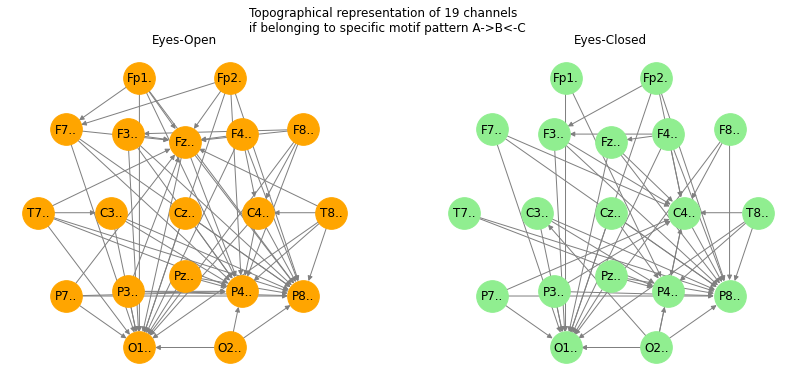

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6), sharey=True)
nx.draw(G_pattern_OE, pos, with_labels=True, node_color='orange', edge_color='gray', node_size=1000, ax=ax1)
nx.draw(G_pattern_CE, pos, with_labels=True, node_color='lightgreen',edge_color='gray', node_size=1000, ax=ax2)
f.suptitle('Topographical representation of 19 channels \n if belonging to specific motif pattern A->B<-C')
ax1.set_title('Eyes-Open')
ax2.set_title('Eyes-Closed')
plt.show()

# EX 3.3

In [ ]:
def po8_motif(filename):
  dict_po8 = {}
  involve = []
  count = 0
  c = False
  with open(filename, 'r') as file:
      for i, line in enumerate(file.readlines()):
          if line.strip().split(' ')[0] == 'subgraph':
              key = line.strip()
              dict_po8[key] = "NOT INVOLVE"
              c = True
          if len(line.strip().split()) == 1 and c:
              count += 1
          if line.strip().split('\t')[0].isnumeric() and count ==1 and c:
              if '60' in list(line.strip().split('\t')):
                  dict_po8[key] = "INVOLVE"  
                  involve.append(key)
                  c = False
          if count == 2:
              count=0 
  return dict_po8, involve

In [ ]:
dict_po8_OE, involve_OE = po8_motif(filename='/content/drive/MyDrive/Bio-project/project2/motif_open_MEMBERS_3dim.txt')
dict_po8_CE, involve_CE = po8_motif(filename='/content/drive/MyDrive/Bio-project/project2/motif_close_MEMBERS_3dim.txt')

print(involve_OE)
print()
print(involve_CE)


['subgraph id = 6', 'subgraph id = 38', 'subgraph id = 74', 'subgraph id = 108']

['subgraph id = 6', 'subgraph id = 14', 'subgraph id = 38', 'subgraph id = 74', 'subgraph id = 108', 'subgraph id = 238']


# EX 4

In [ ]:
#!pip install CDlib
#!pip install cdlib[C]

In [ ]:
arr_OE = np.array(OE)
arr_CE = np.array(CE)
dtfval_OE = estimator(arr_OE, 'DTF')
dtfval_CE = estimator(arr_CE, 'DTF')
G_OE, adj_mat_OE, mat_OE = adj_matrix(0.05, 10, dtfval_OE)
G_OE = nx.relabel_nodes(G_OE, mapping)
G_CE, adj_mat_CE, mat_CE = adj_matrix(0.05, 10, dtfval_CE)
G_CE = nx.relabel_nodes(G_CE, mapping)

the right treshold is 0.24
density = 0.04935515873015873
the right treshold is 0.26
density = 0.048859126984126984


In [ ]:
from cdlib import algorithms
import matplotlib.pyplot as plt
from cdlib import viz
import numpy as np

coms_infomap_OE = algorithms.infomap(G_OE)
coms_infomap_CE = algorithms.infomap(G_CE)

coms_newman_OE = algorithms.girvan_newman(G_OE, level=3)
coms_newman_CE = algorithms.girvan_newman(G_CE, level=3)

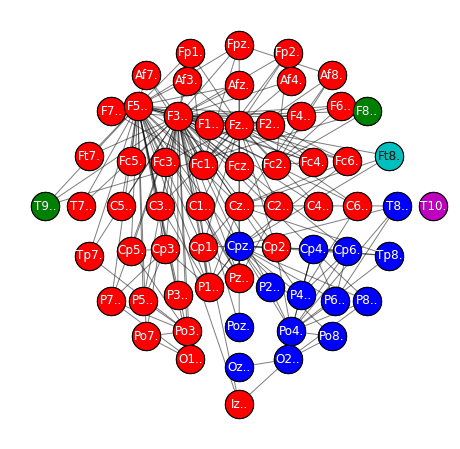

In [ ]:
viz.plot_network_clusters(G_OE, coms_newman_OE, position= pos, plot_labels=True, node_size=800)

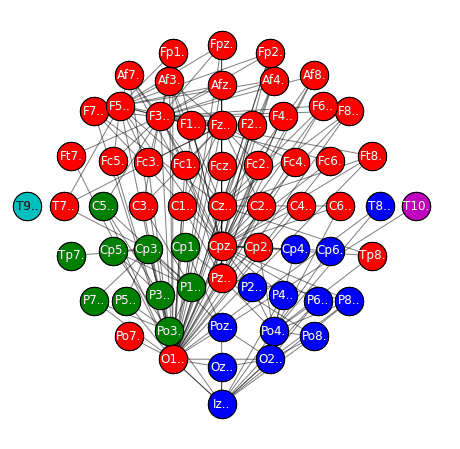

In [ ]:
viz.plot_network_clusters(G_CE, coms_newman_CE, position= pos, plot_labels=True, node_size=800)